In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from numba import jit

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

KeyboardInterrupt: 

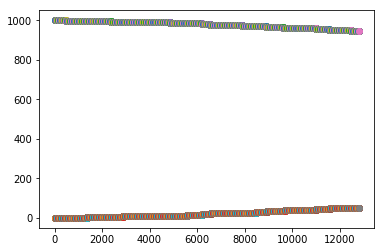

In [16]:
Tl=np.ones(1000)
Pb=np.zeros(1000)
t=0
tau=3052*60

p=1-2**(-1/tau)


while np.sum(Tl)>400:
    for i in range(1000):
        if np.random.random(1)<p:
            Tl[i]=0
            Pb[i]=1
    plt.plot(t,np.sum(Tl),'o',t,np.sum(Pb),'o')
    #np.append(nTl,np.sum(Tl))
    #np.append(nPb,np.sum(Pb))
    t+=1


In [24]:
Tl=1000
Pb=0
t=0
tau=3052*60

p=1-2**(-1/tau)


nTl=np.array([])
nPb=np.array([])

nTl=np.append(nTl,1000)
nPb=np.append(nPb,0)

while nTl[-1]>500:
    for i in np.arange(Tl):   
        if np.random.random()<p:
            Tl-=1
    nTl=np.append(nTl,Tl)
    nPb=np.append(nPb, 1000-Tl)
    
plt.plot(np.arange(len(nTl)),nTl,'o',np.arange(len(nPb)),nPb,'o')

KeyboardInterrupt: 

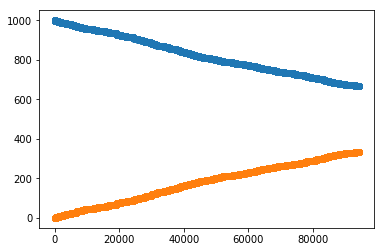

In [25]:
plt.plot(np.arange(len(nTl)),nTl,'o',np.arange(len(nPb)),nPb,'o')

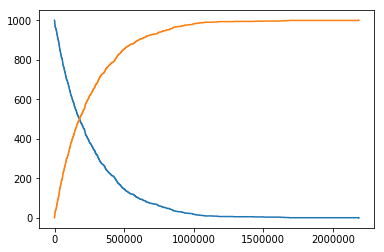

In [65]:
#versione veloce


@jit(nopython=True, parallel =True)
def evolution(Ain, Bin, tau):
    Ae=[]
    Be=[]
    A=Ain
    B=0
    while A>0:
        for i in range(A):
            if  np.random.rand()<1-2**(-1/tau):
                A-=1
                B+=1
        Ae.append(A)
        Be.append(B)
    return Ae, Be


Tl = 1000
Pb = 0
tau=3052*60

T,P = evolution(Tl,Pb,tau)
time = np.arange(len(T))
plt.plot(time, T, time, P)

Trovo la distribuzione comulativa a partire da $$p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$$.
Ossia faccio $$\int^{+\infty}_{0}e^{-t\cdot \ln 2 /\tau}\frac{\ln 2}{\tau}=-e^{-t\cdot \ln 2 /\tau}$$
Quindi partendo da quest'ultima dove z è uniforme: $$z=-e^{-t\cdot \ln 2 /\tau}$$
La inverto e trovo la variabile distribuita come la distribuzione voluta: $$t=-\frac{\tau}{\ln 2}\cdot \ln z$$

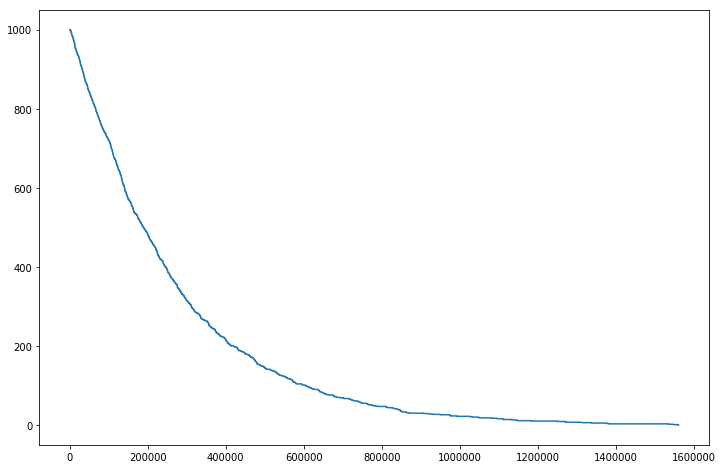

In [24]:
z=np.random.random(1000)
t=np.array([])


tau=3052*60
for i in range(1000):
    t=np.append(t,-tau*(np.log(z[i]))/np.log(2))
    
    
    
time=np.round(t)

nTl=np.zeros(int(max(time))+1)
c=1000

for i in range(int(np.round(max(time)))+1):
    if i in time:
        cont=len(time[time==i])
        c-=cont
    nTl[i]=c

    
    
fig, ax = plt.subplots(figsize=(12, 8))
#ax.hist(t,histtype='step', bins=50, density=True, linewidth=2)
ax.plot(np.arange(len(nTl)), nTl)

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [34]:
N=1000000
beam=np.random.normal(scale=0.529*10**(-9)/100,size=(N,2))

E=7.7*1.609*10**(-13)

b=np.zeros(N)
for i in range(N):
    b[i]=(beam[i,0]**2+beam[i,1]**2)**(1/2)
b

array([1.97286022e-12, 8.51227976e-12, 5.30058800e-12, ...,
       2.66648656e-12, 2.33566737e-12, 4.51812671e-12])

In [39]:
const=79*(1.609*10**(-19))**2/(2*np.pi*8.89*10**(-12)*E)
theta=2*np.arctan(const/b)
len(theta[theta>np.pi/2])/N

1.3e-05

In [60]:
#Versione giusta

z = np.random.random(N)
u = np.random.random(N)
r_squared = -2*(0.529*10**(-9)/100)**(2)*np.log(z)   #qui calcolo r^2 ossia il quadrato anche del parametro d'impatto
b = np.sqrt(r_squared)


const=79*(1.609*10**(-19))**2/(2*np.pi*8.89*10**(-12)*E)
theta=2*np.arctan(const/b)
len(theta[theta>np.pi/2])/N


2.7e-05

3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [95]:

def f(x):
    return np.sin(1/(x*(2-x)))**2


N=10000
count=0
for i in range(N):
    x=2*np.random.random()  #nelle x il dominio va da 0 a 2
    y=np.random.random()    #mentre la y va da 0 a 1 perché la funzione seno quadro va da 0 a 1
    if y<f(x): count+=1
I=2*count/N
print('Risultato dell integrale:',I, 'errore:',np.abs(np.round((I-1.4514),6)))

Risultato dell integrale: 1.4524 errore: 0.001


In [96]:
x=2*np.random.random(N)
I=2/N*np.sum(f(x))
print('Risultato dell integrale:',I, 'errore:',np.abs(np.round((I-1.4514),6)))

Risultato dell integrale: 1.4408080533497385 errore: 0.010592


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [97]:
c=0
for i in range(N):
    x=np.random.random()
    y=np.random.random()
    if x**2+y**2<1:
        c+=1
I=c/N*4
print('Risultato dell integrale:',I, 'errore:',np.abs(np.round((I-np.pi),6)))

Risultato dell integrale: 3.13 errore: 0.011593


In [98]:

c=0
for i in range(N):
    x=np.random.rand(10)
    r=(x**2).sum()
    if r<1:
        c+=1
I=c/N*2**10
print('Risultato dell integrale:',I, 'errore:',np.abs(np.round((I-np.pi**5/(120)),6)))


Risultato dell integrale: 2.7648 errore: 0.214636


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [133]:
N=1000000
def f(x):
    return x**(-1/2)/(np.exp(x)+1)

def w(x):
    return x**(-1/2)

x=np.random.random(N)
I=1/N*np.sum(f(x)/w(x))*2    #molitplico per 2 perché litegrale di w(x) in quell'intervallo fa 2

print('Risultato dell integrale:',I, 'errore:',np.abs(np.round((I-0.84),3)))


Risultato dell integrale: 0.7596453250060426 errore: 0.08


In [134]:
N=1000000
def f(x):
    return x**(-1/2)/(np.exp(x)+1)

def w(x):
    return 1

x=np.random.random(N)
I=1/N*np.sum(f(x)/w(x))    

print('Risultato dell integrale:',I, 'errore:',np.abs(np.round((I-0.84),3)))
#funziona meglio mean value method

Risultato dell integrale: 0.8397015333507849 errore: 0.0
